In [1]:
Data_path = 'PLAID/'

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import shutil
csv_path = Data_path + 'CSV/'
csv_files = os.listdir(csv_path)
print(csv_path)

PLAID/CSV/


In [3]:
import subprocess

def read_data_given_id(path,ids,progress=False,last_offset=0):
    '''read data given a list of ids and CSV paths'''
    n = len(ids)
    if n == 0:
        return {}
    else:
        data = {}
        for (i,ist_id) in enumerate(ids, start=1):
            if progress:
                print('%d/%d is being read...'%(i,n))
            if last_offset==0:
                data[ist_id] = np.genfromtxt(path+str(ist_id)+'.csv',
                delimiter=',',names='current,voltage',dtype=(float,float))
            else:
                p=subprocess.Popen(['tail','-'+str(int(offset)),path+
                    str(ist_id)+'.csv'],stdout=subprocess.PIPE)
                data[ist_id] = np.genfromtxt(p.stdout,delimiter=',',
                    names='current,voltage',dtype=(float,float))
        return data

In [4]:
import json

with open(Data_path + 'meta1.json') as data_file:    
    meta1 = json.load(data_file)


meta = [meta1]

In [5]:
def clean_meta(ist):
    '''remove '' elements in Meta Data ''' 
    clean_ist = ist.copy()
    for k,v in ist.items():
#         if 
        if len(v) == 0:
            del clean_ist[k]
    return clean_ist
                
def parse_meta(meta):
    '''parse meta data for easy access'''
    M = {}
    for m in meta:
        for app in m:
            M[int(app['id'])] = clean_meta(app['meta'])
    return M

In [6]:
def mvPLAIDCSVFile(fileName, applianceList):
    os.mkdir('./PLAIDsets/%s'%fileName)
    old_path = "./PLAID/CSV/"
    new_path = "./PLAIDsets/%s/"%fileName
    for rootdir, filedir, filenames in os.walk(old_path):
        for filename in filenames:
            fileNum, fileType = filename.split('.', 1)
            if int(fileNum) in applianceList:
                old_name = old_path + '/' + filename
                new_name = new_path + '/' + filename
                shutil.copyfile(old_name, new_name)

In [7]:
Meta = parse_meta(meta)

In [8]:
Types = [x['type'] for x in Meta.values()]
# unique appliance types
Unq_type = list(set(Types))

In [9]:
Unq_type

['Fan',
 'Vacuum',
 'Laptop',
 'Compact Fluorescent Lamp',
 'Washing Machine',
 'Incandescent Light Bulb',
 'Hairdryer',
 'Air Conditioner',
 'Fridge',
 'Heater',
 'Microwave']

In [10]:
# for i in range(len(Unq_type)):
#     applianceList = []
#     for j in range(1, 1075):
#         if Meta[j]['type'] == Unq_type[i]:
#             applianceList.append(j)
#     mvPLAIDCSVFile(Unq_type[i], applianceList)

# 轨迹生成图像

In [11]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.signal as signal
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
#import cv2
#sns.set_style('darkgrid')
import matplotlib
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import matplotlib.cm as cm

In [12]:
def find_max_index(ste_volatge):
    reset = 0
    result_list = []
    data = []
    get_voltage = list(ste_volatge)
    for i in range(1000):
        result_list.append(get_voltage.index(max(get_voltage)))
        get_voltage[get_voltage.index(max(get_voltage))] = reset
    result_list.sort()
    for i in range(len(result_list) - 1):
        if abs(result_list[i] - result_list[i+1]) > 100:
            data.append(result_list[i] - 50)
    return data

In [13]:
def rolling_window(ste_data, winlen):
    df = pd.Series(ste_data, index=range(len(ste_data)))
    return np.array(df.rolling(window=winlen).mean().dropna(), dtype=np.float32)

In [14]:
def zero_mean(ste_data):
    return (2 *(ste_data - np.min(ste_data)) / (np.max(ste_data) - np.min(ste_data))) - 1

In [15]:
# def odd(num, N):
#     if num > 0:
#         rest_num =  (num - 1/N)
#         if rest_num > 0:
#             return int(N/2) + int(rest_num*N / 2) + 1
#         else:
#             return int(N/2)
#     else:
#         rest_num = (abs(num) - 1/N)
#         if rest_num>0:
#             return int(N/2) - int(N *rest_num/ 2) - 1
#         else:
#             return int(N/2)
# def even(num, N):
#     if num >= 0:
#         return int(N * num / 2) + N/2
#     else:
#         return int(N/2) - int(N*abs(num)/2) - 1

In [16]:
def odd(num, N):
    if num > 0:
        rest_num =  (num - 1/N)
        if rest_num > 0:
            return int(N/2) + int(rest_num*N / 2) + 1
        else:
            return int(N/2)
    else:
        rest_num = (abs(num) - 1/N)
        if rest_num>0:
            return int(N/2) - int(N *rest_num/ 2) - 1
        else:
            return int(N/2)
def even(num, N):
    if num >= 0:
        if int(N * num / 2) + N / 2 <= N - 1:
            return int(N * num / 2) + N/2
        else:
            return N - 1
    else:
        if int(N/2) - int(N*abs(num)/2) >= 0:
            return int(N/2) - int(N*abs(num)/2)
        else:
            return 0

In [17]:
# data_test = pd.read_csv('./PLAID/CSV/585.csv', names = ['current', 'voltage'])
# _I = np.array(data_test['current'][-30000:-25000], dtype=np.float32)
# _V = np.array(data_test['voltage'][-30000:-25000], dtype=np.float32)
# _I = rolling_window(rolling_window(zero_mean(_I), 10), 10)
# _V = rolling_window(rolling_window(zero_mean(_V), 10), 10)

In [18]:
# data_peak_index = find_max_index(_V)
# data = []
# for i in range(data_peak_index[2], data_peak_index[3]+10, 100):
#     data.append(i)
# norm_len_cur_my = _I[data[0]:data[-1]]
# norm_len_vol_my = _V[data[0]:data[-1]]

In [19]:
# for i in range(len(_I)):
#     if int(even(_I[i],28)) <0 or  int(even(_V[i],28)) <0:
#         print(int(even(_V[i],28)), int(even(_V[i],28)))

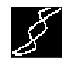

In [32]:
fig = plt.figure(figsize=(5,5))

trajectory = np.zeros([36,36])
for i in range(len(_I)):
    trajectory[int(even(_V[i],36))][int(even(_I[i],36))] = 1
plt.imshow(trajectory[::-1],cmap = cm.Greys_r,interpolation='None')
plt.tick_params(axis='both',which='both',labelbottom='off',labelleft='off')
fig.set_size_inches(70/100.0,70/100.0)#输出width*height像素
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace =0, wspace =0)
plt.margins(0,0)
plt.savefig('./fan.jpg', cmap=cm.Greys_r)#path为你将保存图片的路径。

In [20]:
# os.mkdir(targetPath)

In [26]:
def makeBinaryImage(originalPath,targetPath,appliance):
    targetPath = targetPath + os.sep + appliance
    originalPath = originalPath + os.sep + appliance
    if not (os.path.exists(targetPath)):
        os.mkdir(targetPath)
    for rootdir, dirname, filenames in os.walk(originalPath):
        for filename in filenames:
            fileNum, fileType = filename.split('.', 1)
            data_test = pd.read_csv(originalPath + os.sep + filename, 
                                    names = ['current', 'voltage'])
            _I = np.array(data_test['current'][-10000:-5000], dtype=np.float32)
            _V = np.array(data_test['voltage'][-10000:-5000], dtype=np.float32)
            _I = rolling_window(rolling_window(zero_mean(_I), 10), 10)
            _V = rolling_window(rolling_window(zero_mean(_V), 10), 10)
            fig = plt.figure(figsize=(1,1))
            trajectory = np.zeros([16,16])
            #print(fileNum)
            for i in range(len(_I)):
                trajectory[int(even(_V[i],16))][int(even(_I[i],16))] = 1
            plt.imshow(trajectory[::-1],cmap = cm.Greys_r,interpolation='None')
            plt.plot(_I, _V)
            plt.tick_params(axis='both',which='both',labelbottom='off',labelleft='off')
            fig.set_size_inches(70/100.0,70/100.0)#输出width*height像素
            plt.gca().xaxis.set_major_locator(plt.NullLocator())
            plt.gca().yaxis.set_major_locator(plt.NullLocator())
            plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace =0, wspace =0)
            plt.margins(0,0)
            plt.savefig(targetPath + os.sep + fileNum + '.jpg')#path为你将保存图片的路径。
            plt.clf()

In [28]:
# for i in Unq_type:
#     makeBinaryImage('./PLAIDsets/CSVset/', './PLAIDsets/16x16/', i)

In [23]:
# for rootdir, filedir, filenames in os.walk('./PLAIDsets/16x16/'):
# #     print(filenames)

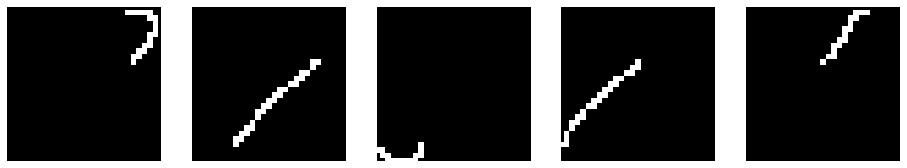

In [39]:
import matplotlib.cm as cm
fig = plt.figure(figsize=(16,10))
for j in range(5):
    trajectory_I1 = norm_len_cur_my[j*100:(j+1)*100]
    trajectory_V1 = norm_len_vol_my[j*100:(j+1)*100]
    ax = fig.add_subplot(1,5,j+1)
    ax.set_xlim(0,28)
    ax.set_ylim(0,28)
    # plt.xticks(np.linspace(0,28, num=28))
    # plt.yticks(np.linspace(0,28, num=28))
    trajectory = np.zeros([29,29])
    for i in range(len(trajectory_I1)):
        trajectory[int(even(trajectory_V1[i],28))][int(even(trajectory_I1[i],28))] = 1
#     fig.set_size_inches(50/100.0,50/100.0)#输出width*height像素
#     plt.gca().xaxis.set_major_locator(plt.NullLocator())
#     plt.gca().yaxis.set_major_locator(plt.NullLocator())
#     plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace =0, wspace =0)
#     plt.margins(0,0)
#     plt.savefig('./%s.jpg'%j)#path为你将保存图片的路径。
    plt.imshow(trajectory,cmap = cm.Greys_r,interpolation='None')
    plt.tick_params(axis='both',which='both',labelbottom='off',labelleft='off')
    

    plt.axis('off')
    #plt.grid()